In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore")
sns.set(style='white', context='talk')

TRAILER_ROOT  = os.path.expanduser("~/Downloads/trailers")
AUDIO_OUT     = os.path.expanduser("~/derivatives/audio")
VISUAL_DIR    = os.path.join(AUDIO_OUT, "visuals")
FRAME_DIR     = os.path.join(VISUAL_DIR, "frames")

os.makedirs(FRAME_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

chunk_dur   = 0.96
window_secs = 15
step_secs   = 5
WINSZ       = int(window_secs / chunk_dur)
STEP        = int(step_secs   / chunk_dur)
BATCH_SIZE  = 16
N_JOBS      = 12

video_paths = [
    os.path.join(TRAILER_ROOT, f)
    for f in sorted(os.listdir(TRAILER_ROOT))
    if f.lower().endswith(".mp4")
]


In [2]:
def extract_096fps(video_path, out_dir):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 24
    skip = max(1, int(round(fps * chunk_dur)))
    seg = os.path.basename(video_path).rsplit('.', 1)[0]
    seg_dir = os.path.join(out_dir, seg)
    os.makedirs(seg_dir, exist_ok=True)
    idx = saved = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % skip == 0:
            cv2.imwrite(os.path.join(seg_dir, f"{seg}_frame_{idx}.jpg"), frame)
            saved += 1
        idx += 1
    cap.release()
    print(f"[{seg}] extracted {saved} frames")

for vp in video_paths:
    extract_096fps(vp, FRAME_DIR)

[A_Quiet_Place_Day1] extracted 103 frames
[Alien_Romulus] extracted 66 frames
[BEETLEJUICE_BEETLEJUICE] extracted 80 frames
[BLINK_TWICE] extracted 168 frames
[Borderlands] extracted 181 frames
[CUCKOO] extracted 151 frames
[Deadpool_Wolverine] extracted 166 frames
[Despicable_Me_4] extracted 153 frames
[Fly_Me_To_The_Moon] extracted 151 frames
[GLADIATOR_2 NEEDS EDIT] extracted 87 frames
[GLADIATOR_2] extracted 77 frames
[HAROLD_PURPLE_CRAYON NEEDS EDIT] extracted 135 frames
[HAROLD_PURPLE_CRAYON] extracted 128 frames
[Inside_Out_2] extracted 151 frames
[Joker_Folie_Deux] extracted 151 frames
[KRAVEN_HUNTER NEEDS EDIT] extracted 197 frames
[KRAVEN_HUNTER] extracted 190 frames
[LEE] extracted 68 frames
[Longlegs] extracted 89 frames
[MOANA_2 NEEDS EDIT] extracted 88 frames
[MOANA_2] extracted 74 frames
[SONIC_3 NEEDS EDIT] extracted 102 frames
[SONIC_3] extracted 91 frames
[Speak_No_Evil] extracted 183 frames
[TWISTERS] extracted 125 frames
[The_Crow] extracted 187 frames
[The_Instigat

In [3]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fe        = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model     = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=fe.image_mean, std=fe.image_std)
])
class FrameDataset(Dataset):
    def __init__(self, paths):
        self.paths = sorted(paths)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i):
        return transform(Image.open(self.paths[i]).convert("RGB"))

In [4]:
def process_segment(seg):
    seg_dir = os.path.join(FRAME_DIR, seg)
    jpgs = sorted(glob.glob(os.path.join(seg_dir, f"{seg}_frame_*.jpg")))
    if not jpgs:
        print(f"[{seg}] no frames"); return seg, None
    dl = DataLoader(FrameDataset(jpgs), batch_size=BATCH_SIZE,
                    shuffle=False, num_workers=0)
    feats = []
    for batch in dl:
        batch = batch.to(device)
        with torch.no_grad():
            out = model(batch).last_hidden_state.mean(dim=1).cpu().numpy()
        feats.append(out)
    feats = np.vstack(feats)
    out_path = os.path.join(VISUAL_DIR, f"{seg}_sampled_960ms_features.npy")
    np.save(out_path, feats)
    print(f"[{seg}] saved {feats.shape}")
    return seg, feats.shape

segments = [os.path.basename(p).rsplit('.',1)[0] for p in video_paths]
Parallel(n_jobs=N_JOBS)(delayed(process_segment)(seg) for seg in segments)

[('A_Quiet_Place_Day1', (103, 768)),
 ('Alien_Romulus', (66, 768)),
 ('BEETLEJUICE_BEETLEJUICE', (80, 768)),
 ('BLINK_TWICE', (168, 768)),
 ('Borderlands', (181, 768)),
 ('CUCKOO', (151, 768)),
 ('Deadpool_Wolverine', (166, 768)),
 ('Despicable_Me_4', (153, 768)),
 ('Fly_Me_To_The_Moon', (151, 768)),
 ('GLADIATOR_2 NEEDS EDIT', (87, 768)),
 ('GLADIATOR_2', (77, 768)),
 ('HAROLD_PURPLE_CRAYON NEEDS EDIT', (135, 768)),
 ('HAROLD_PURPLE_CRAYON', (128, 768)),
 ('Inside_Out_2', (151, 768)),
 ('Joker_Folie_Deux', (151, 768)),
 ('KRAVEN_HUNTER NEEDS EDIT', (197, 768)),
 ('KRAVEN_HUNTER', (190, 768)),
 ('LEE', (68, 768)),
 ('Longlegs', (89, 768)),
 ('MOANA_2 NEEDS EDIT', (88, 768)),
 ('MOANA_2', (74, 768)),
 ('SONIC_3 NEEDS EDIT', (102, 768)),
 ('SONIC_3', (91, 768)),
 ('Speak_No_Evil', (183, 768)),
 ('TWISTERS', (125, 768)),
 ('The_Crow', (187, 768)),
 ('The_Instigator NEEDS EDITmp4', (81, 768)),
 ('The_Instigator', (71, 768)),
 ('VENOM_3 NEEDS EDIT', (104, 768)),
 ('VENOM_3', (91, 768)),
 ('

In [5]:
def apply_moving_average(feats, target_dim=128):
    groups = feats.shape[1] // target_dim
    return feats.reshape(feats.shape[0], target_dim, groups).mean(axis=2)

for seg in segments:
    arr = np.load(os.path.join(VISUAL_DIR, f"{seg}_sampled_960ms_features.npy"))
    red = apply_moving_average(arr)
    np.save(os.path.join(VISUAL_DIR, f"{seg}_reduced_moving_avg_features.npy"), red)
print("Embeddings reduced from 768 to 128")

Embeddings reduced from 768 to 128


In [6]:
visual = {
    seg: np.load(os.path.join(VISUAL_DIR, f"{seg}_reduced_moving_avg_features.npy"))
    for seg in segments
}

records = []
for i, s1 in enumerate(segments):
    A, n1 = visual[s1], visual[s1].shape[0]
    for s2 in segments[i+1:]:
        B, n2 = visual[s2], visual[s2].shape[0]
        for t0 in range(0, n1-WINSZ+1, STEP):
            win1 = A[t0:t0+WINSZ].ravel().reshape(1,-1)
            for u0 in range(0, n2-WINSZ+1, STEP):
                win2 = B[u0:u0+WINSZ].ravel().reshape(1,-1)
                r = cosine_similarity(win1, win2)[0,0]
                z = np.arctanh(np.clip(r, -0.999999, 0.999999))
                records.append({
                    'vid1': s1, 'vid2': s2,
                    'v1_start_s': round(t0*chunk_dur,2),
                    'v2_start_s': round(u0*chunk_dur,2),
                    'sim_z': z
                })
df_slide = pd.DataFrame(records)
df_slide.to_csv(os.path.join(VISUAL_DIR, "visual_pair_similarity.csv"), index=False)

In [7]:
best = (
    df_slide.groupby(['vid1','vid2'])['sim_z']
           .mean()
           .reset_index()
           .sort_values(['vid1','sim_z'], ascending=[True, False])
           .groupby('vid1').first().reset_index()
)
print("Top match for each trailer")
print(best.to_string(index=False))

Top match for each trailer
                           vid1                 vid2    sim_z
             A_Quiet_Place_Day1           White_Bird 0.285640
                  Alien_Romulus              VENOM_3 0.303434
        BEETLEJUICE_BEETLEJUICE              SONIC_3 0.234131
                    BLINK_TWICE           White_Bird 0.268713
                    Borderlands   Deadpool_Wolverine 0.275871
                         CUCKOO           White_Bird 0.246352
             Deadpool_Wolverine           White_Bird 0.279632
                Despicable_Me_4         Inside_Out_2 0.207771
             Fly_Me_To_The_Moon           White_Bird 0.273634
                    GLADIATOR_2           White_Bird 0.275757
         GLADIATOR_2 NEEDS EDIT          GLADIATOR_2 0.629261
           HAROLD_PURPLE_CRAYON             Longlegs 0.210359
HAROLD_PURPLE_CRAYON NEEDS EDIT HAROLD_PURPLE_CRAYON 0.390764
                   Inside_Out_2              SONIC_3 0.203462
               Joker_Folie_Deux           W

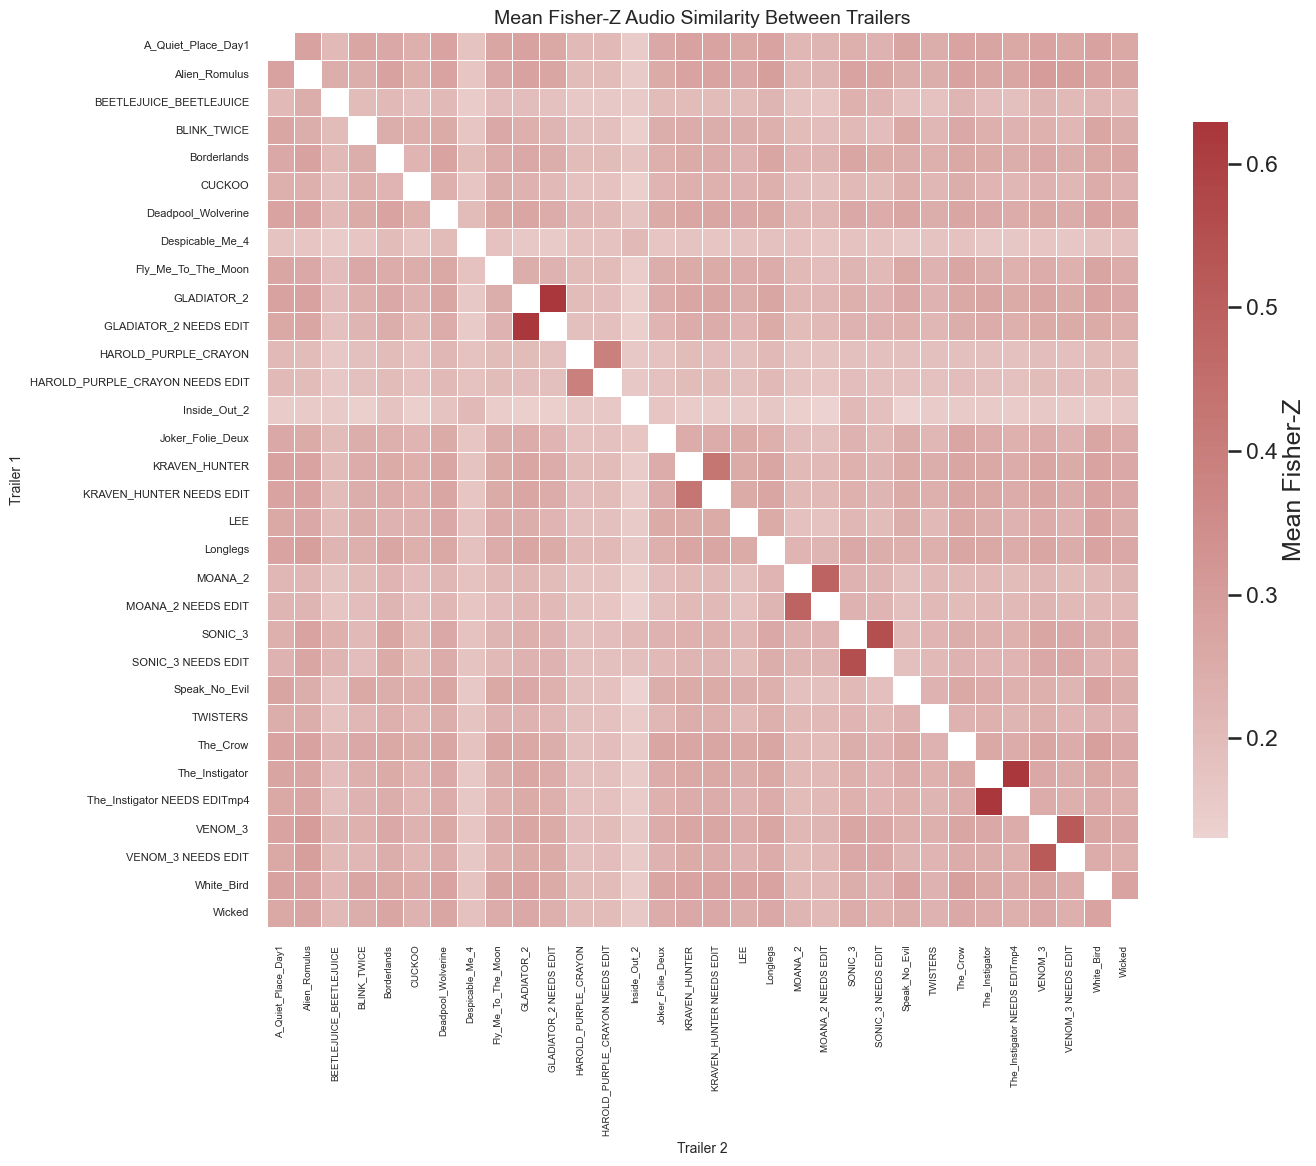

In [8]:
import numpy as np

mean_df = df_slide.groupby(["vid1","vid2"])["sim_z"].mean().reset_index()
rev     = mean_df.rename(columns={"vid1":"vid2","vid2":"vid1"})
full    = pd.concat([mean_df, rev], ignore_index=True)

mat = full.pivot(index="vid1", columns="vid2", values="sim_z")

fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(
    mat,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    annot=False,
    ax=ax,
    cbar_kws={'shrink': 0.8, 'label': 'Mean Fisher-Z'}
)

n = len(mat.columns)
ax.set_xticks(np.arange(n) + 0.5) 
ax.set_xticklabels(mat.columns, rotation=90, fontsize=7, ha='center')
ax.set_yticks(np.arange(len(mat.index)) + 0.5)
ax.set_yticklabels(mat.index, rotation=0, fontsize=8)

ax.set_xlabel("Trailer 2", fontsize=10)
ax.set_ylabel("Trailer 1", fontsize=10)
ax.set_title("Mean Fisher-Z Audio Similarity Between Trailers", fontsize=14)

plt.tight_layout()
plt.show()


In [9]:
skip_rate  = 5
downscale  = (320, 240)

def compute_color_entropy(img, bins=(8,8,8)):
    hist = cv2.calcHist([img],[0,1,2],None,bins,[0,256,0,256,0,256]).flatten()
    p = hist/hist.sum() if hist.sum()>0 else np.ones_like(hist)/hist.size
    return float(entropy(np.where(p==0,1e-12,p), base=2))

def process_video_folder(seg):
    path = os.path.join(FRAME_DIR, seg)
    files = sorted(f for f in os.listdir(path) if f.lower().endswith('.jpg'))
    hist_vals, face_cnt, body_cnt, motions = [],0,0,[]
    prev_gray = None
    sample_count = 0

    face_cas = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    hog = cv2.HOGDescriptor(); hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    for idx, fname in enumerate(files):
        img = cv2.imread(os.path.join(path, fname))
        if img is None:
            continue

        hist_vals.append(compute_color_entropy(img))
        
        if idx % skip_rate == 0:
            sample_count += 1
            small = cv2.resize(img, downscale)
            gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

            faces = face_cas.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=3, 
                minSize=(24,24),   
                flags=cv2.CASCADE_SCALE_IMAGE
            )
            if len(faces) > 0:
                face_cnt += 1

            rects, _ = hog.detectMultiScale(small, winStride=(8,8), padding=(8,8), scale=1.05)
            if len(rects) > 0:
                body_cnt += 1

            if prev_gray is not None:
                diff = cv2.absdiff(gray, prev_gray).astype(np.float32)/255.0
                motions.append(diff.mean())
            prev_gray = gray

    arr = visual.get(seg)
    if arr is None:
        tv_var = pace = 0
    else:
        tv_var = float(np.var(arr, axis=0).mean())
        pace   = float(np.linalg.norm(np.diff(arr, axis=0), axis=1).mean())

    return {
        'hist_entropy':      np.mean(hist_vals)           if hist_vals    else 0,
        'face_pct':          face_cnt  / sample_count    if sample_count else 0,
        'body_pct':          body_cnt  / sample_count    if sample_count else 0,
        'motion_dyn':        np.mean(motions)            if motions      else 0,
        'temporal_variance': tv_var,
        'editing_pace':      pace
    }

segments = sorted([
    d for d in os.listdir(FRAME_DIR)
    if os.path.isdir(os.path.join(FRAME_DIR, d))
])
print(f"Found {len(segments)} trailers to analyze ", segments)

stats    = Parallel(n_jobs=N_JOBS)(delayed(process_video_folder)(seg) for seg in segments)
df_stats = pd.DataFrame(stats, index=segments)
df_stats.to_csv(os.path.join(VISUAL_DIR, 'visuals_extra.csv'))
print(df_stats)


Found 32 trailers to analyze  ['A_Quiet_Place_Day1', 'Alien_Romulus', 'BEETLEJUICE_BEETLEJUICE', 'BLINK_TWICE', 'Borderlands', 'CUCKOO', 'Deadpool_Wolverine', 'Despicable_Me_4', 'Fly_Me_To_The_Moon', 'GLADIATOR_2', 'GLADIATOR_2 NEEDS EDIT', 'HAROLD_PURPLE_CRAYON', 'HAROLD_PURPLE_CRAYON NEEDS EDIT', 'Inside_Out_2', 'Joker_Folie_Deux', 'KRAVEN_HUNTER', 'KRAVEN_HUNTER NEEDS EDIT', 'LEE', 'Longlegs', 'MOANA_2', 'MOANA_2 NEEDS EDIT', 'SONIC_3', 'SONIC_3 NEEDS EDIT', 'Speak_No_Evil', 'TWISTERS', 'The_Crow', 'The_Instigator', 'The_Instigator NEEDS EDITmp4', 'VENOM_3', 'VENOM_3 NEEDS EDIT', 'White_Bird', 'Wicked']
                                 hist_entropy  face_pct  body_pct  motion_dyn  \
A_Quiet_Place_Day1                   2.120058  0.142857  0.476190    0.154443   
Alien_Romulus                        0.828034  0.000000  0.285714    0.072516   
BEETLEJUICE_BEETLEJUICE              2.766302  0.187500  0.125000    0.213550   
BLINK_TWICE                          2.950119  0.294118  0.500

<Figure size 640x480 with 0 Axes>

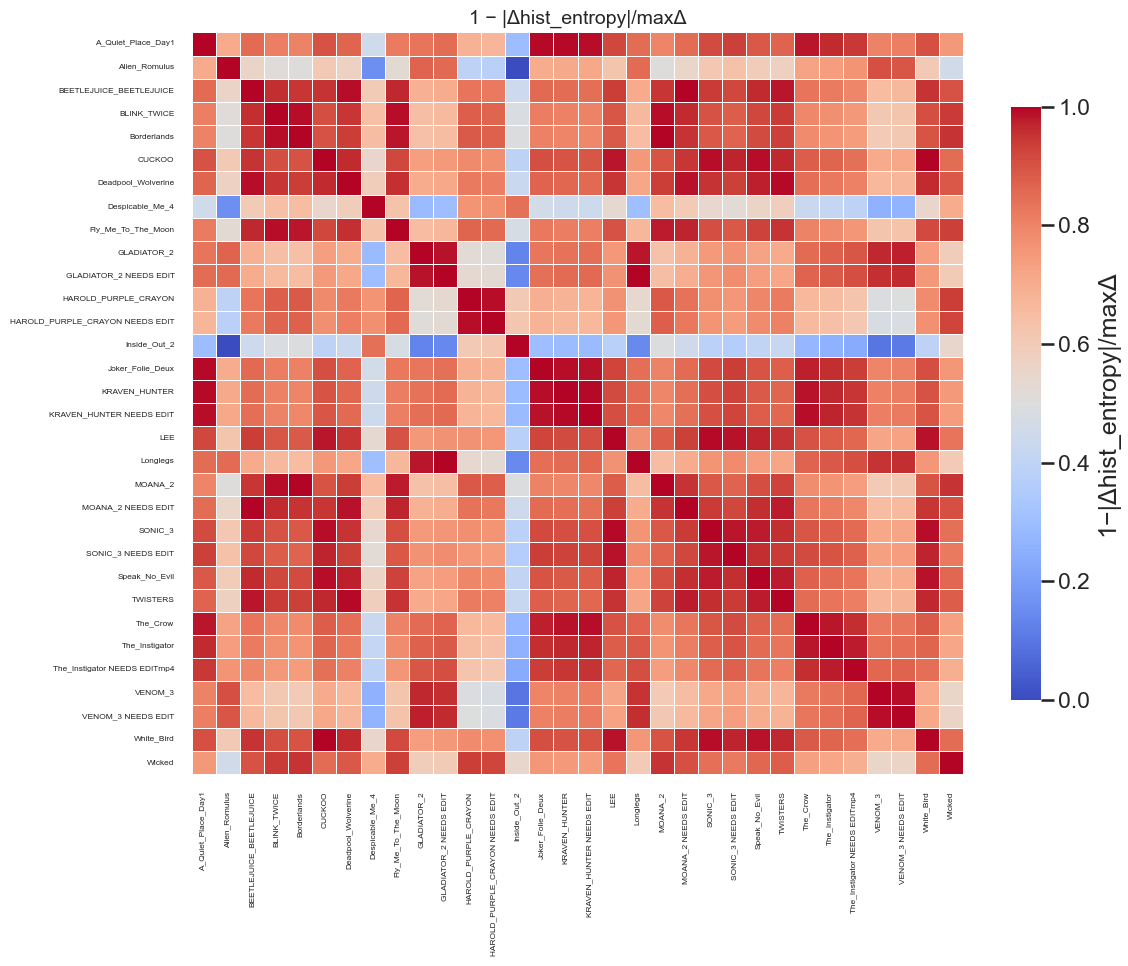

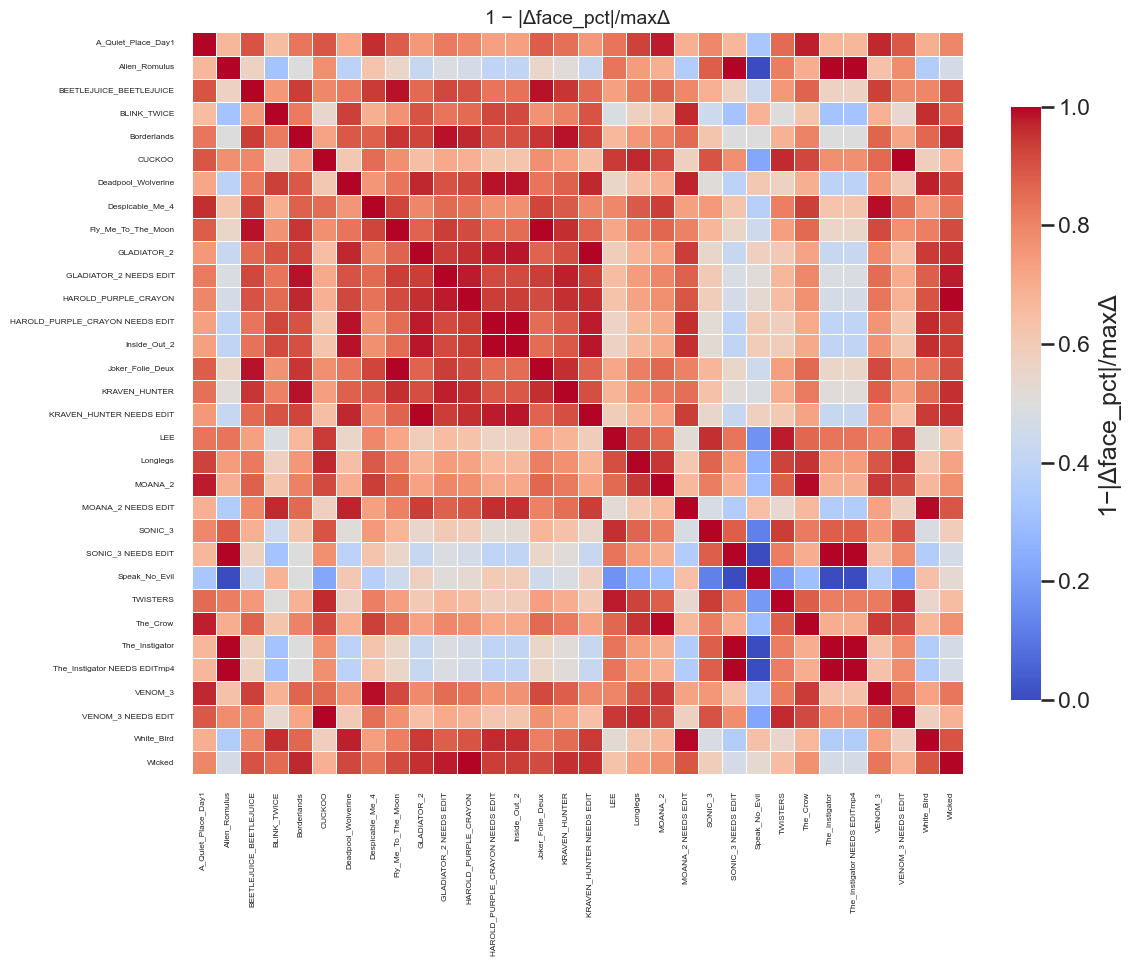

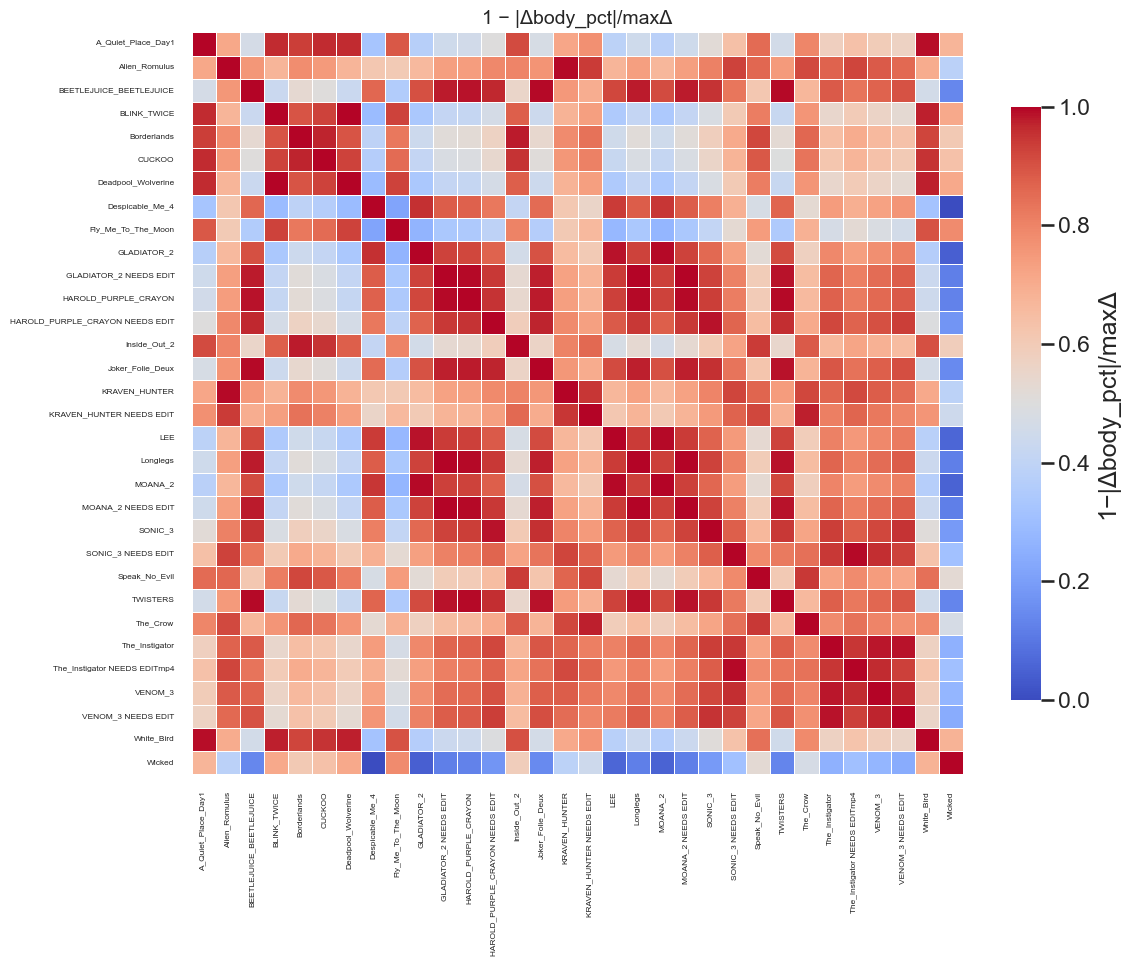

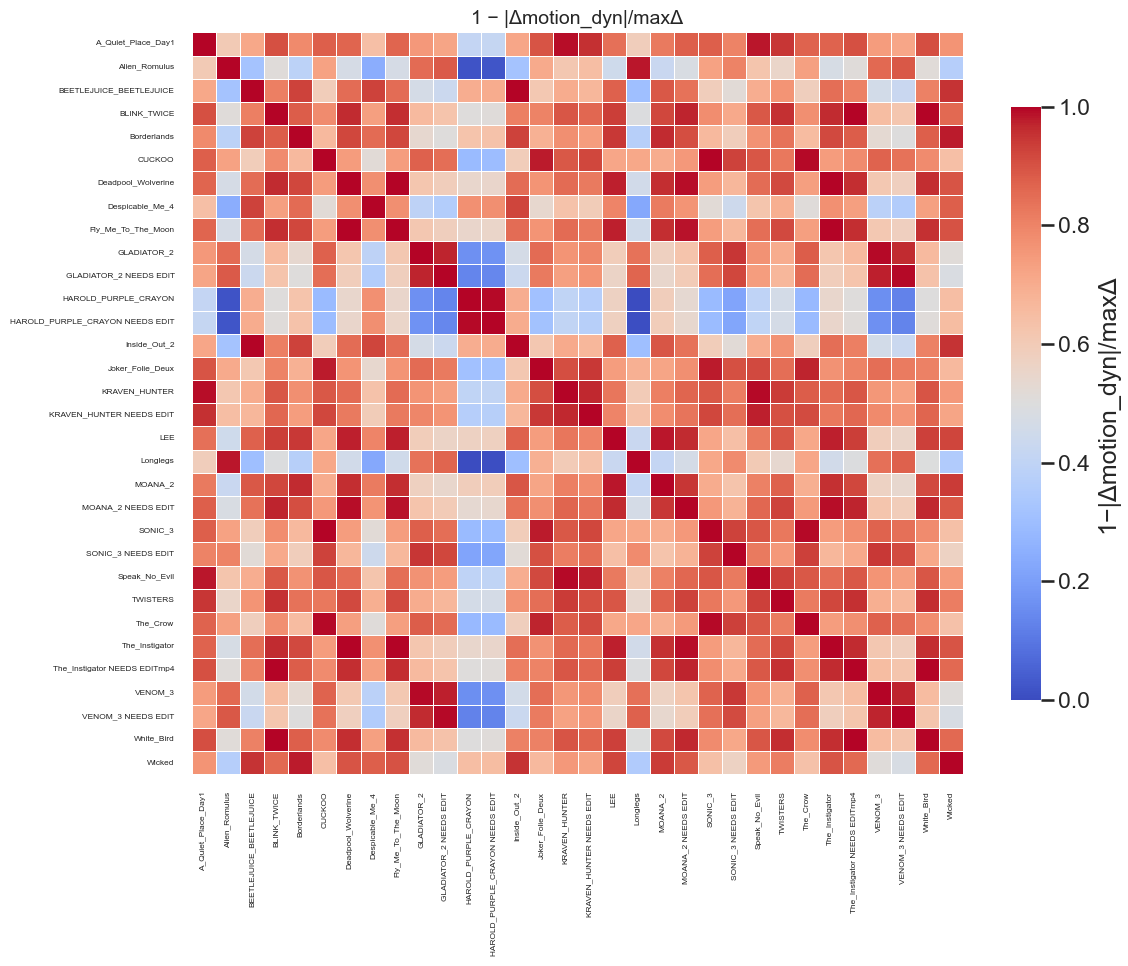

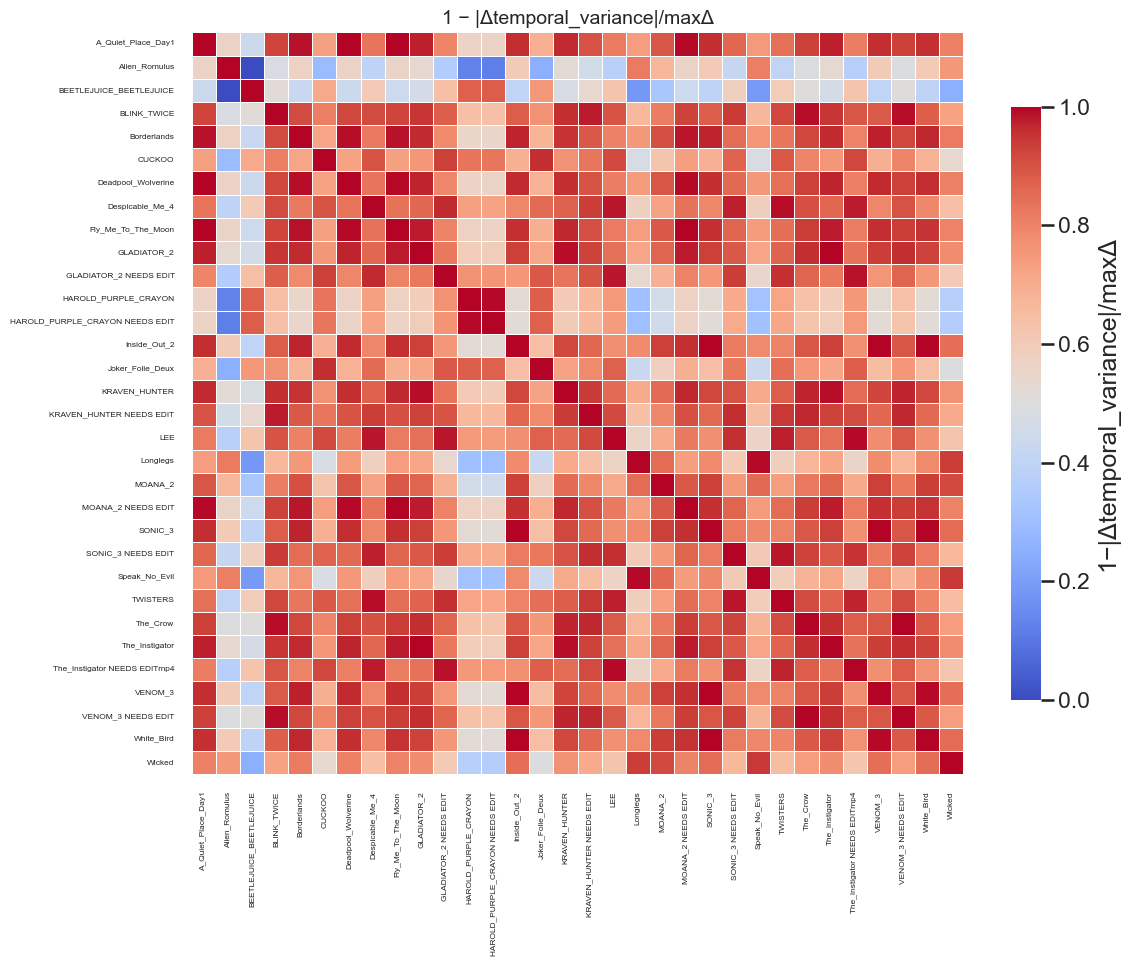

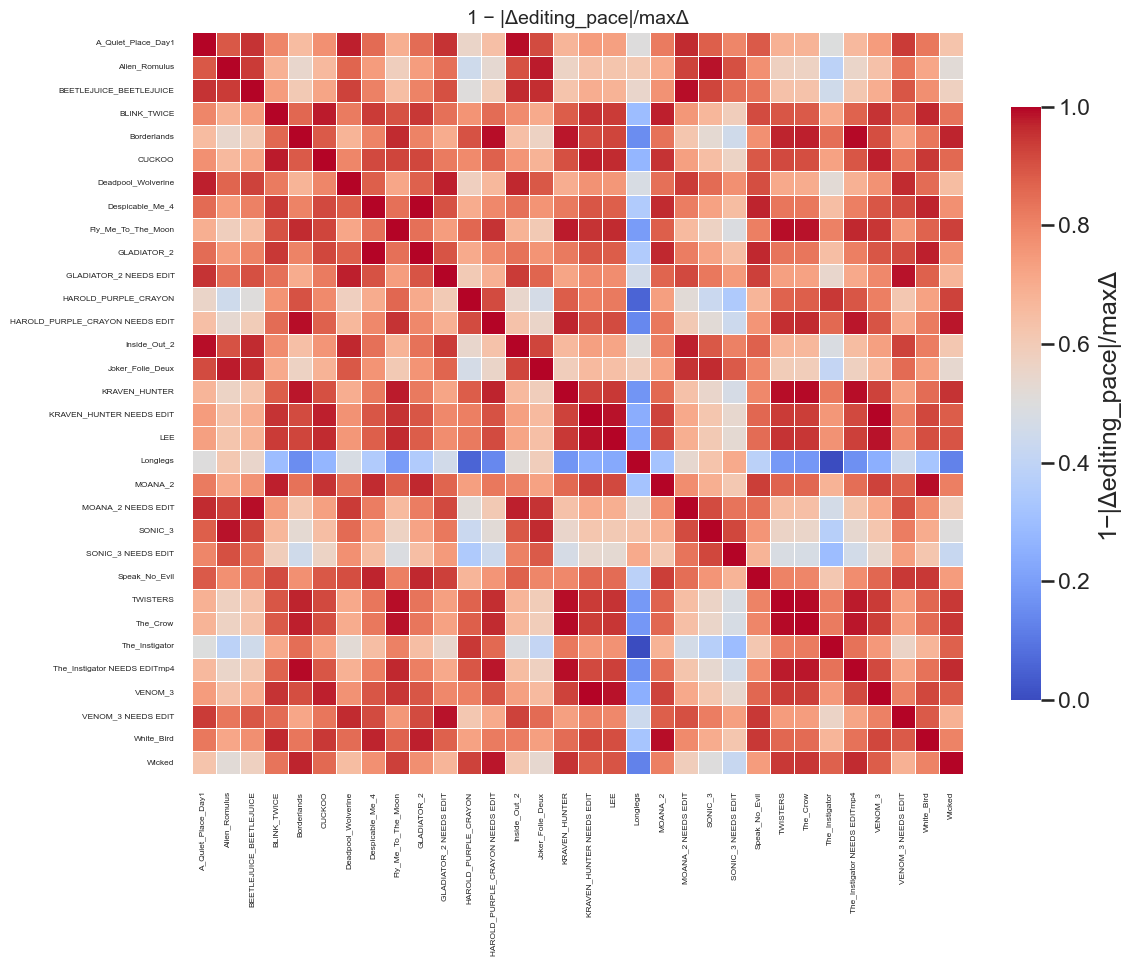

In [10]:

n = len(segments)
ax.set_xticks(np.arange(n)+0.5)
ax.set_yticks(np.arange(n)+0.5)
ax.set_xticklabels(segments, rotation=90, fontsize=6, ha='center')
ax.set_yticklabels(segments, rotation=0,  fontsize=6)

plt.tight_layout()
plt.show()

for feat in df_stats.columns:
    vals = df_stats[feat].values[:, None]
    diff = np.abs(vals - vals.T)
    sim  = 1 - (diff / diff.max())
    sim_df = pd.DataFrame(sim, index=segments, columns=segments)

    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(sim_df, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5, ax=ax,
                cbar_kws={'shrink':0.8, 'label':f"1−|Δ{feat}|/maxΔ"})
    ax.set_title(f"1 − |Δ{feat}|/maxΔ", fontsize=14)

    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(n)+0.5)
    ax.set_xticklabels(segments, rotation=90, fontsize=6, ha='center')
    ax.set_yticklabels(segments, rotation=0,  fontsize=6)

    plt.tight_layout()
    plt.show()


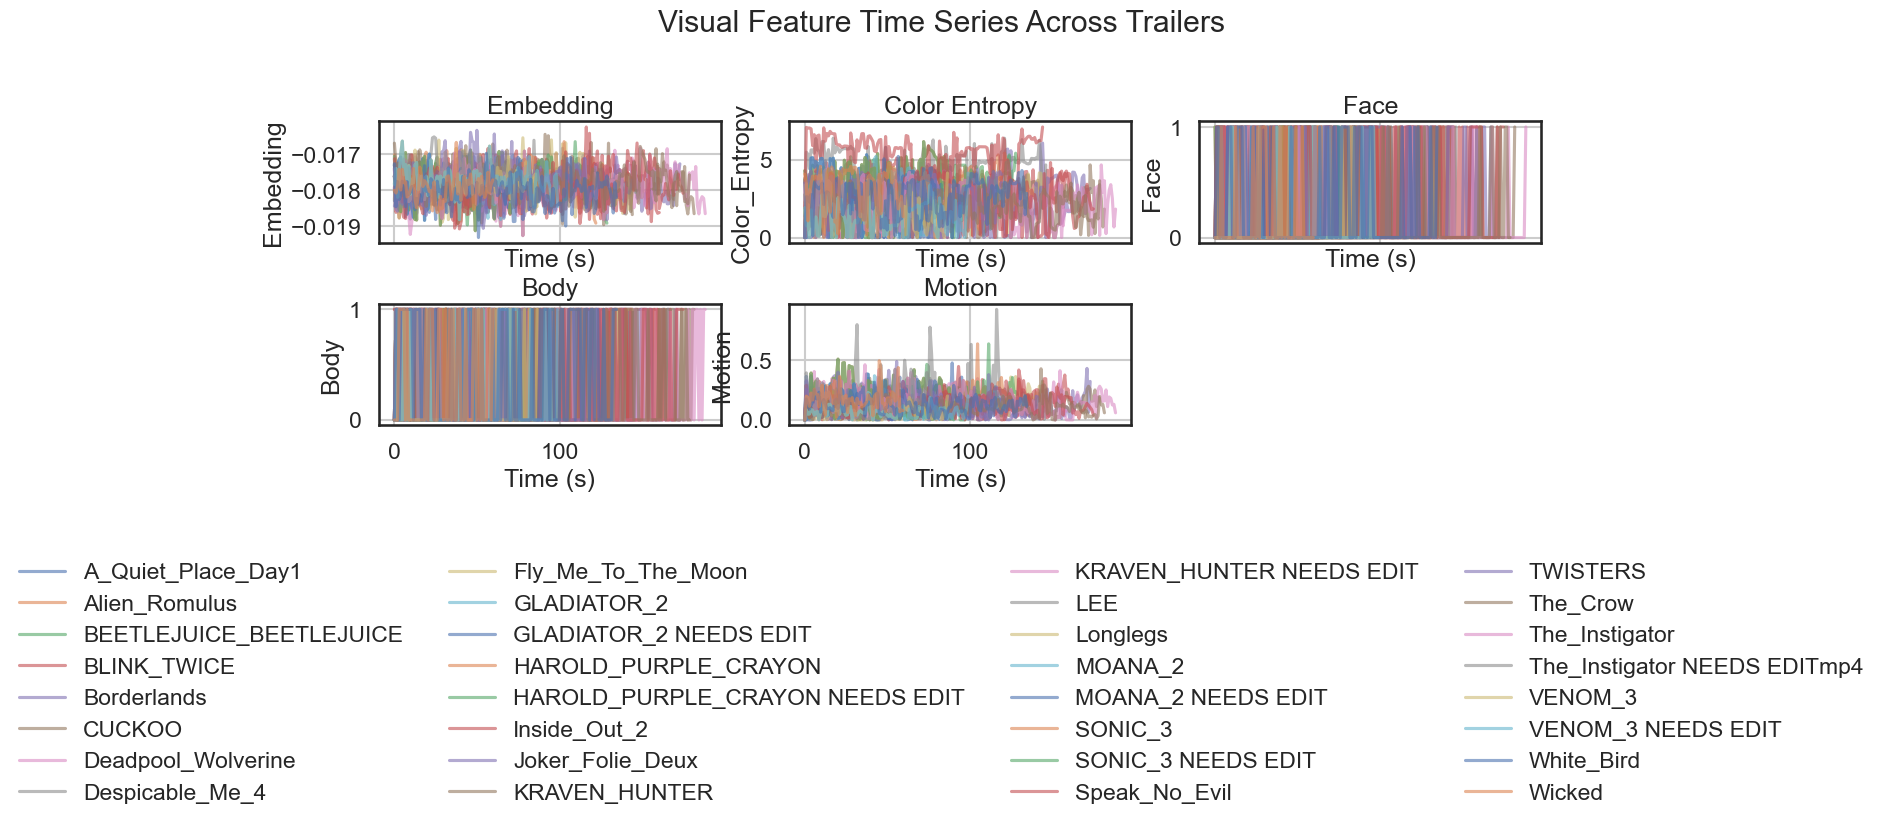

In [11]:
records = []
downscale = (320, 240)
face_cas = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
hog      = cv2.HOGDescriptor(); hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

for seg in segments:
    sampled = np.load(os.path.join(VISUAL_DIR, f"{seg}_reduced_moving_avg_features.npy"))
    n_frames = sampled.shape[0]
    frame_files = sorted(glob.glob(os.path.join(FRAME_DIR, seg, f"{seg}_frame_*.jpg")))
    prev_gray = None

    for idx in range(n_frames):
        t = idx * chunk_dur
        emb = sampled[idx].mean()
        img = cv2.imread(frame_files[idx])
        small = cv2.resize(img, downscale)
        gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

        hist = cv2.calcHist([img],[0,1,2],None,(8,8,8),[0,256]*3).flatten()
        p = hist/hist.sum() if hist.sum()>0 else np.ones_like(hist)/hist.size
        col_ent = float(entropy(np.where(p==0,1e-12,p), base=2))

        faces = face_cas.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=3,
            minSize=(24,24),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        face = 1 if len(faces) > 0 else 0
        rects, _ = hog.detectMultiScale(small, winStride=(8,8), padding=(8,8), scale=1.05)
        body = 1 if len(rects)>0 else 0

        if prev_gray is not None:
            motion = float(np.abs(gray.astype(np.float32)-prev_gray.astype(np.float32)).mean()/255.0)
        else:
            motion = 0.0
        prev_gray = gray

        records.append({
            'trailer': seg,
            'time_s': t,
            'embedding': emb,
            'color_entropy': col_ent,
            'face': face,
            'body': body,
            'motion': motion
        })

df_viz = pd.DataFrame(records)

features = ['embedding', 'color_entropy', 'face', 'body', 'motion']
n = len(features)
cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols,4*rows), sharex=True)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    for name, grp in df_viz.groupby('trailer'):
        ax.plot(grp['time_s'], grp[feat], label=name, alpha=0.6)
    ax.set_title(feat.replace('_',' ').title())
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(feat.title())
    ax.grid(True)

for ax in axes[n:]:
    fig.delaxes(ax)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False)
plt.subplots_adjust(hspace=0.5, bottom=0.5)
plt.suptitle("Visual Feature Time Series Across Trailers", y=1.02)
plt.show()

In [12]:
import os
import glob
import shutil


SRC_FRAME_DIR = FRAME_DIR  
DEST_VISUAL_DIR = os.path.expanduser("~/derivatives/visuals")


os.makedirs(DEST_VISUAL_DIR, exist_ok=True)

for seg in segments:
    src_dir = os.path.join(SRC_FRAME_DIR, seg)
    dest_dir = os.path.join(DEST_VISUAL_DIR, seg)
    os.makedirs(dest_dir, exist_ok=True)
    for img_file in glob.glob(os.path.join(src_dir, f"{seg}_frame_*.jpg")):
        shutil.copy(img_file, os.path.join(dest_dir, os.path.basename(img_file)))

print(f"Copied all frames to {DEST_VISUAL_DIR}")


Copied all frames to /Users/aarondumas/derivatives/visuals
